In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.feature_engineering import *
from utils.plot_distributions import *

# Load data

In [2]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [3]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [4]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]

# find where precip in anomalously high
precip_outliers = np.where(regions_precip > 100)[0]
drop_idx = regions.index[precip_outliers]

# drop outlier precip data from input and labels
regions = regions.drop(drop_idx)
labels = labels.drop(drop_idx)

In [5]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


# Feature engineering

Let's create some interesting features as aggregates of meteorological data we already have.

In [6]:
# get wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

# Cluster variables by danger level

In [7]:
# let's look at danger level first
danger_level = labels.loc[:, ['CLASS_danger_level']]

# danger level ranges from 1 - 4
where_idx1 = danger_level.index[np.where(danger_level == 1)[0]]
where_idx2 = danger_level.index[np.where(danger_level == 2)[0]]
where_idx3 = danger_level.index[np.where(danger_level == 3)[0]]
where_idx4 = danger_level.index[np.where(danger_level == 4)[0]]

assert((len(where_idx1) + len(where_idx2) + len(where_idx3) + len(where_idx4)) == len(danger_level))

In [8]:
# now we can subset our input data by these indices
danger_level_1 = regions.loc[where_idx1]
danger_level_2 = regions.loc[where_idx2]
danger_level_3 = regions.loc[where_idx3]
danger_level_4 = regions.loc[where_idx4]

danger_levels_list = [danger_level_1, danger_level_2, danger_level_3, danger_level_4]

# Plot variables of interest

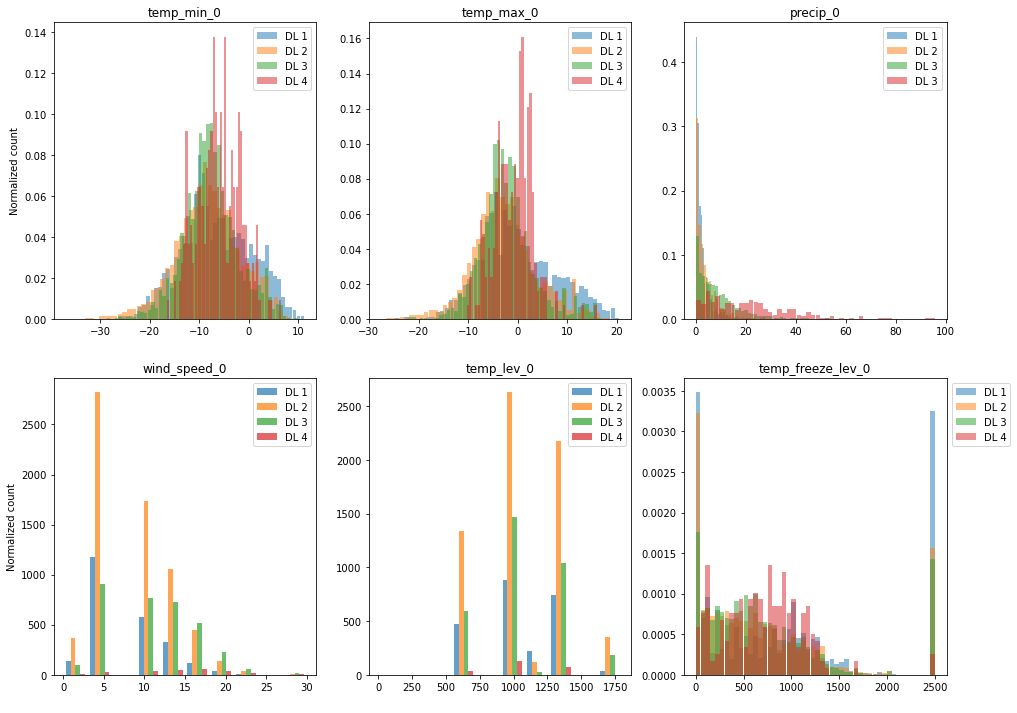

In [9]:
plot_dl_weather(danger_levels_list)

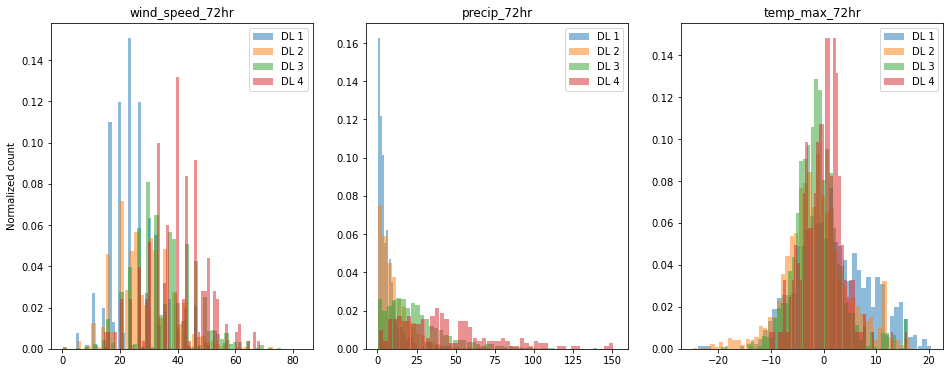

In [10]:
plot_dl_custom_wx(danger_levels_list)